In [1]:
import numpy as np
from scipy.stats import multivariate_normal, norm, chi2
import matplotlib.pyplot as plt

# constants
mean = np.array([0, 0]) # univariate means
stds = np.array([1, 1]) # unviarate stds
x_min, x_max = y_min, y_max = norm(0, 1).ppf([0.025, 0.975]) # univariate RI limits

# define a fine grid over the region of interest
x_values = np.linspace(-5, 5, 3000)  # adjust grid density for accuracy vs speed
y_values = np.linspace(-5, 5, 3000)
X, Y = np.meshgrid(x_values, y_values)
points = np.vstack([X.ravel(), Y.ravel()]).T

# calculate the grid spacing (the area per grid cell)
dx = x_values[1] - x_values[0]
dy = y_values[1] - y_values[0]
grid_area = dx * dy  # area of each grid cell

# ellipse nstd for 95% probability
nstd = np.sqrt(chi2.ppf(0.95, 2))


In [2]:
def region_func(x, y, rv):
    """ Returns pdf of bivariate gaussian rv at x, y position
        For use with nquad
    """
    return rv.pdf([x, y])

def correlation_to_covariance(correlation_matrix, std_devs):
    """ Convert correlation matrix and stds to covariance
    """
    covariance_matrix = np.outer(std_devs, std_devs) * correlation_matrix
    return covariance_matrix
        
def get_gaussian(correlation):
    """ Return a scipy.stats.multivariate_gaussian object
    """
    cor_mat = np.array([[1, correlation], [correlation, 1]])  # variable correlations
    covariance = correlation_to_covariance(cor_mat, stds)
    return multivariate_normal(mean, covariance), covariance

def classify_points_box(x, y):
    inside_box = (x_min <= x <= x_max) and (y_min <= y <= y_max)
    if inside_box:
        return 'inside'
    else:
        return 'outside'
    
def classify_points_ellipse(x, y, inv_cov):
    z = np.array([x - mean[0], y - mean[1]])
    ellipse_value = np.dot(z, np.dot(inv_cov, z))
    inside_ellipse = ellipse_value <= nstd**2
    if inside_ellipse:
        return 'inside'
    else:
        return 'outside'
    
def evaluate_correlation(correlation):
    """ Computes error statistics for univariate RIs against bivariate standard
    """
    rv, cov = get_gaussian(correlation)
    
    # 95% confidence ellipse: Mahalanobis distance boundary
    nstd = np.sqrt(chi2.ppf(0.95, 2))
    inv_cov = np.linalg.inv(cov)

    # evaluate the PDF at each grid point
    pdf_values = rv.pdf(points)
    
    # compute for ellipse
    classifications = np.array([classify_points_ellipse(x, y, inv_cov) for x, y in points])
    P_inside = np.sum(pdf_values[classifications == 'inside']) * grid_area
    P_outside = np.sum(pdf_values[classifications == 'outside']) * grid_area
    print(f"P_inside Ellipse: {P_inside}")
    print(f"P_outside Ellipse: {P_outside}")

    # compute for box
    classifications = np.array([classify_points_box(x, y) for x, y in points])
    P_inside = np.sum(pdf_values[classifications == 'inside']) * grid_area
    P_outside = np.sum(pdf_values[classifications == 'outside']) * grid_area
    print(f"P_inside Box: {P_inside}")
    print(f"P_outside Box: {P_outside}")


In [3]:
# evaluate_correlation(0)


In [4]:
def classify_points_both(x, y, inv_cov):
    z = np.array([x - mean[0], y - mean[1]])
    ellipse_value = np.dot(z, np.dot(inv_cov, z))
    inside_box = (x_min <= x <= x_max) and (y_min <= y <= y_max)
    inside_ellipse = ellipse_value <= nstd**2
    if inside_box and inside_ellipse:
        return [1, 1, 1]
    elif inside_box and not inside_ellipse:
        return [2, 1, 0]
    elif not inside_box and inside_ellipse:
        return [3, 0, 1]
    else:
        return [4, 0, 0]
    
def evaluate_correlation(correlation):
    """ Computes error statistics for univariate RIs against bivariate standard
    """
    rv, cov = get_gaussian(correlation)
    
    # 95% confidence ellipse: Mahalanobis distance boundary
    nstd = np.sqrt(chi2.ppf(0.95, 2))
    inv_cov = np.linalg.inv(cov)

    # evaluate the PDF at each grid point
    pdf_values = rv.pdf(points)
    
    # compute for ellipse
    classifications = np.array([classify_points_both(x, y, inv_cov) for x, y in points])
    
    P_inside_both = np.sum(pdf_values[classifications[:,0] == 1]) * grid_area
    P_outside_both = np.sum(pdf_values[classifications[:,0] == 4]) * grid_area
    P_box_outside_ellipse = np.sum(pdf_values[classifications[:,0] == 2]) * grid_area
    P_ellipse_outside_box = np.sum(pdf_values[classifications[:,0] == 3]) * grid_area
    P_box = np.sum(pdf_values[classifications[:,1] == 1]) * grid_area
    P_ellipse = np.sum(pdf_values[classifications[:,2] == 1]) * grid_area
    
    return {
        'p_inside_both': P_inside_both, 
        'p_box_outside_ellipse': P_box_outside_ellipse,
        'p_ellipse_outside_box': P_ellipse_outside_box,
        'p_outside_both': P_outside_both,
        'p_box': P_box,
        'p_ellipse': P_ellipse
    }
    
corrs = np.linspace(0, 0.9, 10)
results = []
for cor in corrs:
    print(cor)
    results.append(evaluate_correlation(cor))
    

0.0
0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
0.9


In [5]:
tpr = [i['p_outside_both']/(1-i['p_ellipse']) for i in results]
tnr = [i['p_inside_both']/i['p_ellipse'] for i in results]
fpr = [i['p_ellipse_outside_box']/i['p_ellipse'] for i in results]
fnr = [i['p_box_outside_ellipse']/(1-i['p_ellipse']) for i in results]


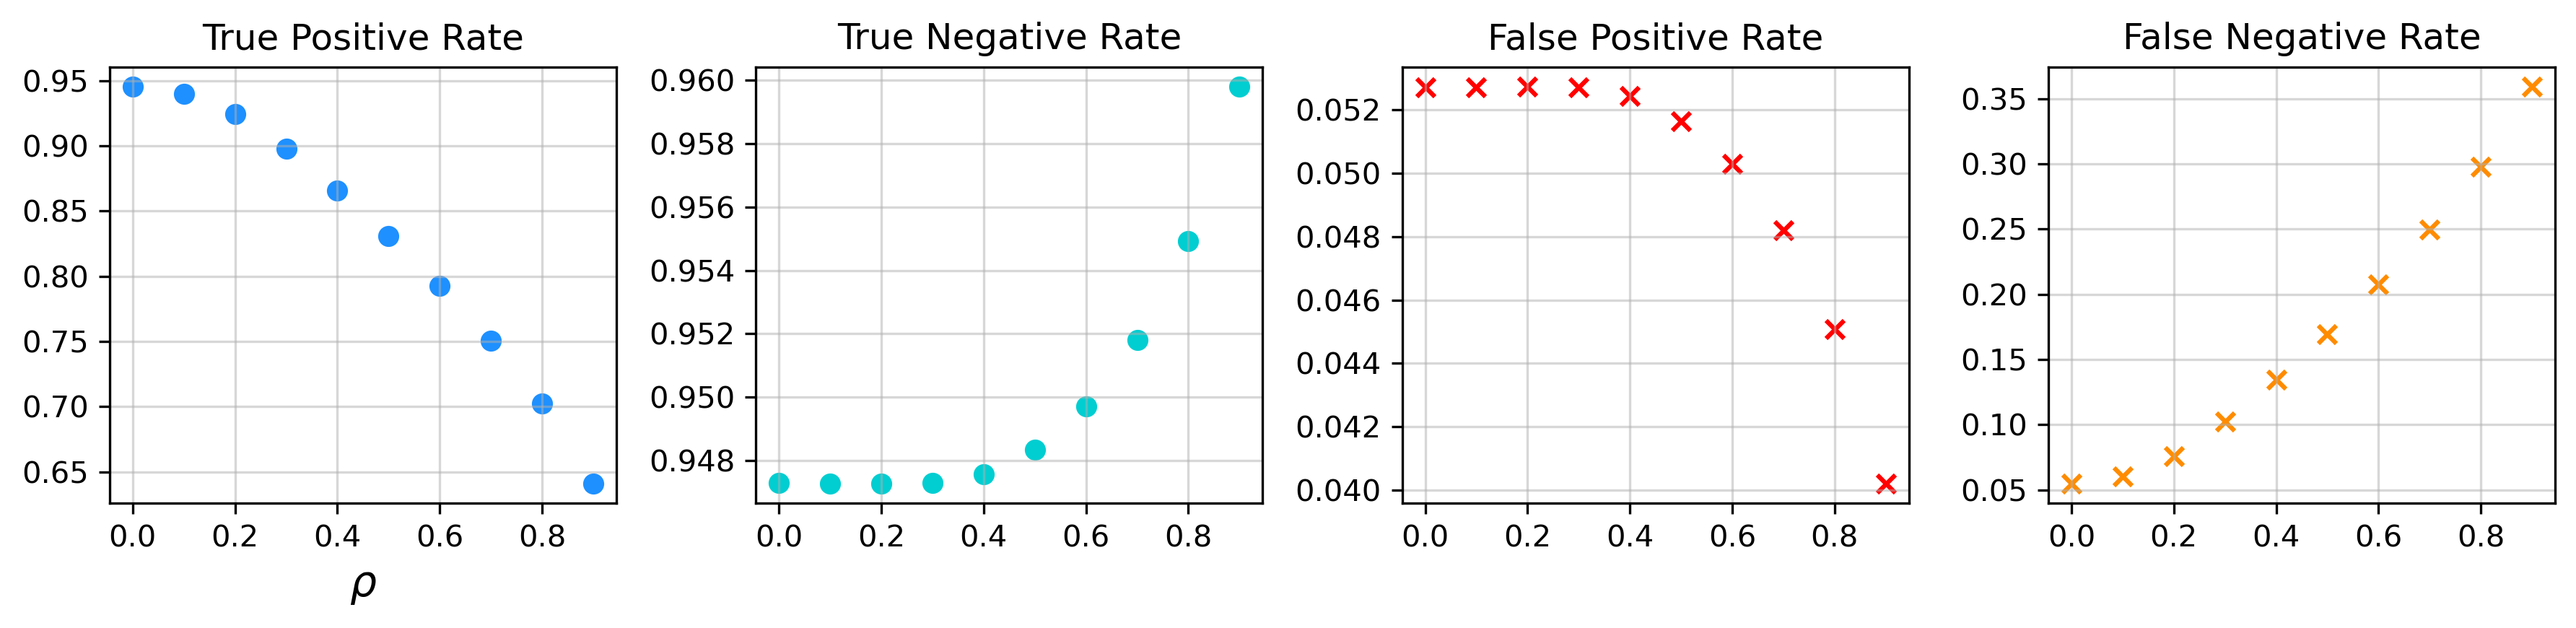

In [6]:
plt.figure(figsize=(12, 3), dpi=300)
plt.subplot(1,4,1)
plt.scatter(corrs, tpr, marker='o', c='dodgerblue')
plt.title('True Positive Rate')
plt.grid(alpha=0.5)
plt.xlabel(r'$ %s $' % '\\rho', fontsize=14)

plt.subplot(1,4,2)
plt.scatter(corrs, tnr, marker='o', c='darkturquoise')
plt.title('True Negative Rate')
plt.grid(alpha=0.5)

plt.subplot(1,4,3)
plt.scatter(corrs, fpr, marker='x', c='red')
plt.title('False Positive Rate')
plt.grid(alpha=0.5)

plt.subplot(1,4,4)
plt.scatter(corrs, fnr, marker='x', c='darkorange')
plt.title('False Negative Rate')
plt.grid(alpha=0.5)

plt.tight_layout();
